# Data Analysis of the House Prices datasets

In this notebook, we are going to to analyse the different variables of the House Prices Daset from the Kaggle Competition: [House Prices: Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)

In [71]:
# === System imports ===
import csv
sys.path.append("../")

# === Third-party import ===

# To handle datasets
import pandas as pd
import numpy as np
from scipy import stats
# To split the dataset
from sklearn.model_selection import train_test_split
# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To display only a limited number of columns of the dataframe in the whole notebook
pd.options.display.max_rows = 1000

# === Local imports ===
import utils
from feature_engineering import remove_outliers


## Load data

- Import the most relevant variables
- Import the dataset and focus on the `most_relevant_variables`

In [72]:
most_relevant_variables = utils.import_list(file_path='../datasets/outputs/most_relevant_variables.csv')

most_relevant_variables

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageArea',
 'TotalBsmtSF',
 'FullBath',
 'TotRmsAbvGrd']

In [73]:
data = pd.read_csv(filepath_or_buffer='../datasets/inputs/train.csv')

target = 'SalePrice'
data = data[most_relevant_variables]
data.head()

,SalePrice,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,FullBath,TotRmsAbvGrd
0,208500,7,1710,548,856,2,8
1,181500,6,1262,460,1262,2,6
2,223500,7,1786,608,920,2,6
3,140000,7,1717,642,756,1,7
4,250000,8,2198,836,1145,2,9


In [74]:
data.shape

(1460, 7)

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SalePrice     1460 non-null   int64
 1   OverallQual   1460 non-null   int64
 2   GrLivArea     1460 non-null   int64
 3   GarageArea    1460 non-null   int64
 4   TotalBsmtSF   1460 non-null   int64
 5   FullBath      1460 non-null   int64
 6   TotRmsAbvGrd  1460 non-null   int64
dtypes: int64(7)
memory usage: 80.0 KB


## Observation

The dataset with only the `most_relevant_variables` contains no missing values

## Split the dataset into train and test

Before beginning to engineer our features, it is important to separate our data intro training and testing set.

**We set the seed to be 0**## Split the dataset into train and test

Before beginning to engineer our features, it is important to separate our data intro training and testing set.

**We set the seed to be 0**

In [76]:
X_train, X_test, y_train, y_test = train_test_split(data, data[target], 
                                                          test_size=0.1, 
                                                          random_state=0)
for dataset in ['X_train', 'X_test', 'y_train', 'y_test']:
    print(f'{dataset}: {eval(dataset).shape}')

X_train: (1314, 7)
X_test: (146, 7)
y_train: (1314,)
y_test: (146,)


## Feature Engineering

### Numerical variables

In [77]:
numerical_variables = ['GrLivArea', 'GarageArea', 'TotalBsmtSF']
data_numerical = data[numerical_variables]

#### Outliers

[Reference](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba): *Ways to Detect and Remove the Outliers*
 
 To have a better visualization of outliers let's display the **Bobplot** of the numerical variables


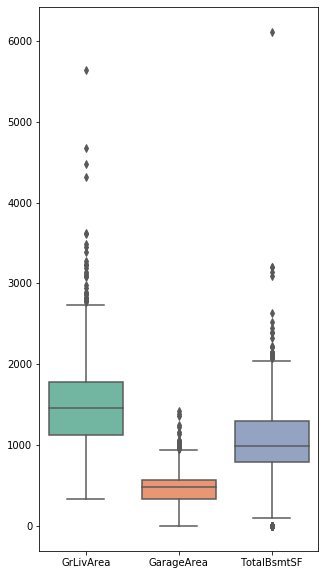

In [78]:
plt.figure(figsize=(5,10))
ax = sns.boxplot(data=data_numerical, orient="v", palette="Set2")

#### Z-score

Let's try to remove some of these outliers with the **z-score** strategy: removing all rows containing at least one variable above the thrshold z-score. <br>Usually we choose a **threshold=3** standard deviations.

We can see the influence of the threshold on the data remove by plotting: <br>
```f(threshold) = %rows removed from initial dataset```

2.0


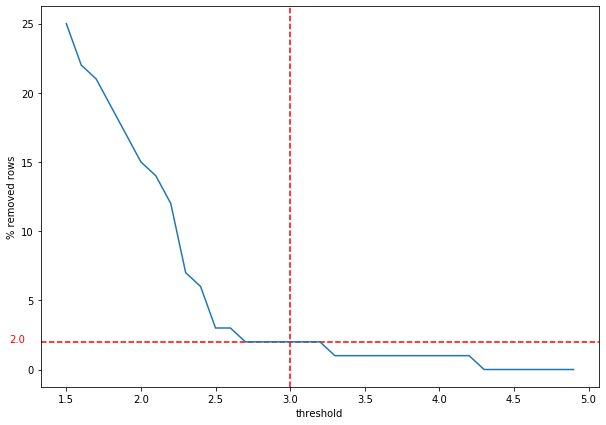

In [79]:
z = np.abs(stats.zscore(data_numerical))
thresholds = np.around(np.arange(1.5, 5.0, 0.1), 2)
percents_removed_rows = []
for threshold in thresholds:
    cleaned_data_numerical = data_numerical[(z < threshold).all(axis=1)]
    percent_removed_rows = round(1 - len(cleaned_data_numerical)/len(data_numerical), 2) * 100
    if threshold == 3.0:
        percent_removed_rows_3 = percent_removed_rows
    cleaned_data_numerical = data_numerical[(z < threshold).all(axis=1)]
    percents_removed_rows.append(percent_removed_rows)


print(percent_removed_rows_3)
plt.figure(figsize=(10, 7))
plt.axvline(x=3, linestyle='--', color='red')
plt.axhline(y=percent_removed_rows_3, linestyle='--', color='red')
plt.text(x=1.12, y=percent_removed_rows_3, s=f'{round(percent_removed_rows_3, 2)}', color = 'red')
plt.xlabel('threshold')
plt.ylabel(f'% removed rows')
ax = plt.plot(thresholds, percents_removed_rows)



By choosing *threshold = 3*, we remove 2% of the rows of the dataframe

#### IQR score

The boxplot displayed further up uses the **IQR mehod**.

Let's see the percentage of removed rows with the standard parameters.

In [80]:
Q1 = data_numerical.quantile(0.25)
Q3 = data_numerical.quantile(0.75)
IQR = Q3 - Q1
is_outlier = (data_numerical < (Q1 - 1.5 * IQR)) | (data_numerical > (Q3 + 1.5 * IQR))
cleaned_data = data_numerical[~is_outlier.any(axis=1)]
print(f"The % of removed rows is {round((1 - len(cleaned_data)/len(data_numerical))*100, 2)}")

The % of removed rows is 6.85


**IQR scoring** seams to be more robust to outliers, as it removes more rows than with **z-scoring**

#### Remove outliers from X_train

We are going to keep the rows reulsting from IQR in `X_train`

In [84]:
print(f"X_train size with outliers: {X_train.shape}")
X_train = remove_outliers(df=X_train, numerical_variables=numerical_variables)
print(f"X_train size without outliers: {X_train.shape}")

X_train size with outliers: (1314, 7)


TypeError: remove_outliers() got an unexpected keyword argument 'numerical_variables'

#### Distribution

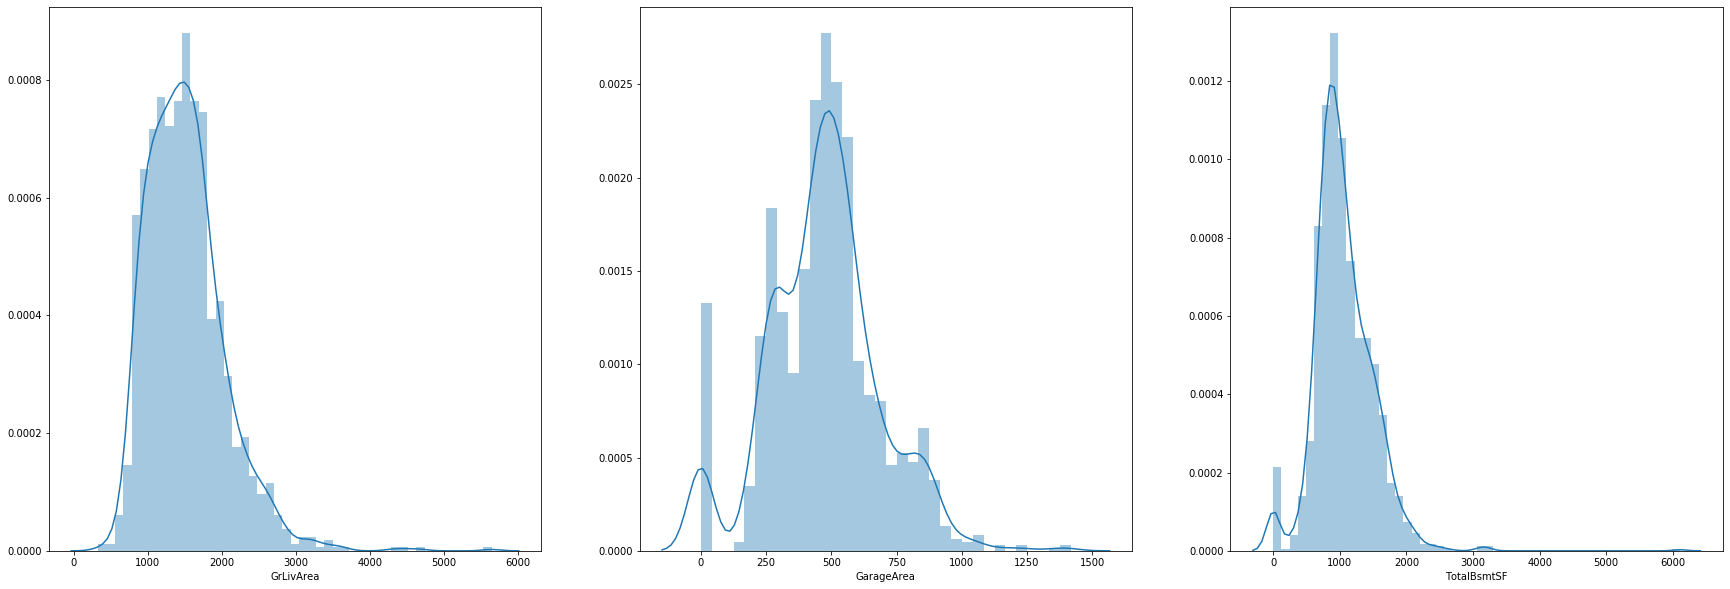

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

for var, ax in zip(numerical_variables, axes.flat):
    sns.distplot(data[var], ax=ax)


Similarily to `SalePrice`, these variables seem to have some skewness.

In [54]:
for var in numerical_variables:
    if any(data[var]==0):
        print(f"{var} contains null values")

GarageArea contains null values
TotalBsmtSF contains null values


Unfortunately the variables: `GarageArea` and `TotalBsmtSF` have null variables in the case where the house has no garage or basement. This makes the logarithmic transformation impossible.

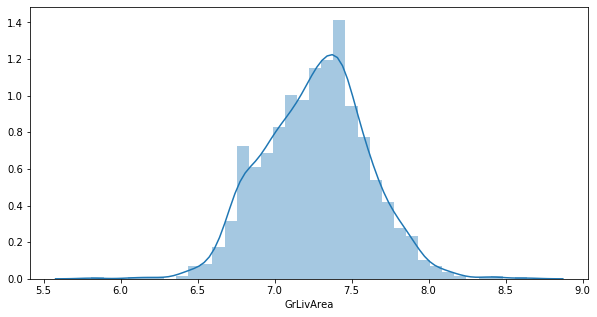

In [55]:
plt.figure(figsize=(10,5))
sns.distplot(np.log(data['GrLivArea']))

However, log-transforming `GrLivArea` can be useful.

We are going to make this transformation for `X_train` and `X_test`

In [56]:
data.head()

,SalePrice,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,FullBath,TotRmsAbvGrd
0,208500,7,1710,548,856,2,8
1,181500,6,1262,460,1262,2,6
2,223500,7,1786,608,920,2,6
3,140000,7,1717,642,756,1,7
4,250000,8,2198,836,1145,2,9


In [57]:
X_train['GrLivArea'] = np.log(X_train['GrLivArea'])
X_test['GrLivArea'] = np.log(X_test['GrLivArea'])

### Categorical variables

In [ ]:
for 
sns.catplot(data=data, 
            x=var,
            kind="count",
            palette="ch:.25")

In [64]:
most_relevant_variables

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageArea',
 'TotalBsmtSF',
 'FullBath',
 'TotRmsAbvGrd']

In [68]:
categorical_variables = ['OverallQual', 'FullBath', 'TotRmsAbvGrd']

In [69]:
data_categorical = data[categorical_variables]
data_categorical

,OverallQual,FullBath,TotRmsAbvGrd
0,7,2,8
1,6,2,6
2,7,2,6
3,7,1,7
4,8,2,9
...,...,...,...
1455,6,2,7
1456,6,2,7
1457,7,2,9
1458,5,1,5
